In [21]:
import numpy as np

from keras.models import load_model, clone_model, Model, Sequential
from keras.layers import Activation, Dense, Softmax
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.datasets import cifar10

from pgd_attack import AdversarialExampleGenerator

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from datetime import datetime
import math

# Restrict GPU memory usage
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
sess = tf.Session(config=config)
set_session(sess)

In [2]:
epsilon = 8 / 255
batch_size = 64
model_path = "saved_models/CIFAR10_SmallResNet_eps_0.031/Apr26_17-05-26/weights_050_0.39.h5"

In [3]:
####################
# Data preparation #
####################

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Leave aside a validation set
x_valid = x_train[-5000:]
y_valid = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

# Input image dimensions
input_shape = x_train.shape[1:]

# Normalize data
x_train = x_train.astype("float32") / 255
x_valid = x_valid.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")

x_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
45000 train samples
5000 validation samples


In [4]:
########################
# Model initialisation #
########################

model = load_model(model_path)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
frozen_model = clone_model(model)

# For some reason we have to re-load the weights
frozen_model.load_weights(model_path)

for l in frozen_model._layers[:-1]:
    l.trainable = False

frozen_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=Adam(lr=1e-4),
                     metrics=["accuracy"])

frozen_model.xent_loss = frozen_model.total_loss
for loss in frozen_model.losses:
    frozen_model.xent_loss -= loss

frozen_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
###################
# Data generators #
###################

train_generator = AdversarialExampleGenerator(frozen_model, x_train, y_train,
                                              batch_size=batch_size,
                                              epsilon=epsilon,
                                              k=8,
                                              a=0.03,
                                              incremental=False)
test_generator =  AdversarialExampleGenerator(frozen_model, x_test, y_test,
                                              batch_size=batch_size,
                                              epsilon=epsilon,
                                              k=40,
                                              a=epsilon / 10.0,
                                              incremental=False)

In [7]:
#######################
# Initial performance #
#######################

frozen_model.evaluate_generator(test_generator, workers=0)

[1.7715986221313476, 0.3782]

In [8]:
#########
# Train #
#########

frozen_model_history = \
    frozen_model.fit_generator(train_generator,
                               validation_data=test_generator,
                               epochs=10,
                               workers=0, # Important for the generators
                               shuffle=False) # Shuffling done in the generators

Epoch 1/10
704/704 [==============================] - 518s 736ms/step - loss: 1.3248 - acc: 0.5312 - val_loss: 1.7760 - val_acc: 0.3793
Epoch 2/10
704/704 [==============================] - 520s 739ms/step - loss: 1.3238 - acc: 0.5334 - val_loss: 1.7767 - val_acc: 0.3799
Epoch 3/10
704/704 [==============================] - 518s 735ms/step - loss: 1.3210 - acc: 0.5347 - val_loss: 1.7785 - val_acc: 0.3789
Epoch 4/10
704/704 [==============================] - 517s 735ms/step - loss: 1.3246 - acc: 0.5310 - val_loss: 1.7822 - val_acc: 0.3772
Epoch 5/10
704/704 [==============================] - 515s 732ms/step - loss: 1.3266 - acc: 0.5290 - val_loss: 1.7827 - val_acc: 0.3776
Epoch 6/10
704/704 [==============================] - 818s 1s/step - loss: 1.3221 - acc: 0.5330 - val_loss: 1.7850 - val_acc: 0.3769
Epoch 7/10
704/704 [==============================] - 1242s 2s/step - loss: 1.3212 - acc: 0.5326 - val_loss: 1.7864 - val_acc: 0.3771
Epoch 8/10
704/704 [==============================] -

## Replace output layer with stack of dense layers

In [22]:
cloned_model = clone_model(model)

cloned_model.load_weights(model_path)

inputs = cloned_model.input

last_hidden_layer_name = "flatten_1"
output_stack = Sequential([Dense(64, kernel_regularizer=l2(1e-4)), Activation("relu"),
                           Dense(64, kernel_regularizer=l2(1e-4)), Activation("relu"),
                           Dense(64, kernel_regularizer=l2(1e-4)), Activation("relu"),
                           Dense(10), Softmax()])
outputs = output_stack(cloned_model.get_layer(last_hidden_layer_name).output)

complex_output_model = Model(inputs=inputs, outputs=outputs)

for l in complex_output_model.layers[:-2]:
    l.trainable = False

complex_output_model.compile(loss="sparse_categorical_crossentropy",
                             optimizer=Adam(lr=1e-4),
                             metrics=["accuracy"])

complex_output_model.xent_loss = complex_output_model.total_loss
for loss in complex_output_model.losses:
    complex_output_model.xent_loss -= loss

complex_output_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
###################
# Data generators #
###################

train_generator = AdversarialExampleGenerator(complex_output_model, x_train, y_train,
                                              batch_size=batch_size,
                                              epsilon=epsilon,
                                              k=8,
                                              a=0.03,
                                              incremental=False)
test_generator =  AdversarialExampleGenerator(complex_output_model, x_test, y_test,
                                              batch_size=batch_size,
                                              epsilon=epsilon,
                                              k=40,
                                              a=epsilon / 10.0,
                                              incremental=False)

In [25]:
#######################
# Initial performance #
#######################

complex_output_model.evaluate_generator(test_generator, workers=0, use_multiprocessing=False)

[2.585489645385742, 0.0526]

In [27]:
#########
# Train #
#########

complex_output_model_history = \
    complex_output_model.fit_generator(train_generator,
                                       validation_data=test_generator,
                                       epochs=10,
                                       workers=0, # Important for the generators
                                       shuffle=False) # Shuffling done in the generators

Epoch 1/10
704/704 [==============================] - 520s 739ms/step - loss: 1.8299 - acc: 0.4028 - val_loss: 1.8079 - val_acc: 0.3596
Epoch 2/10
704/704 [==============================] - 520s 738ms/step - loss: 1.4671 - acc: 0.4928 - val_loss: 1.7892 - val_acc: 0.3735
Epoch 3/10
704/704 [==============================] - 989s 1s/step - loss: 1.4107 - acc: 0.5093 - val_loss: 1.7946 - val_acc: 0.3760
Epoch 4/10
704/704 [==============================] - 1205s 2s/step - loss: 1.3804 - acc: 0.5161 - val_loss: 1.8112 - val_acc: 0.3686
Epoch 5/10
704/704 [==============================] - 1204s 2s/step - loss: 1.3694 - acc: 0.5224 - val_loss: 1.8200 - val_acc: 0.3681
Epoch 6/10
704/704 [==============================] - 1208s 2s/step - loss: 1.3665 - acc: 0.5220 - val_loss: 1.8275 - val_acc: 0.3687
Epoch 7/10
704/704 [==============================] - 1204s 2s/step - loss: 1.3602 - acc: 0.5228 - val_loss: 1.8279 - val_acc: 0.3718
Epoch 8/10
704/704 [==============================] - 537s 

In [28]:
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

In [29]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns == 1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (math.sqrt(5) - 1.0) / 2.0 # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ["\\usepackage[lf,minionint,footnotefigures]{MinionPro}"],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
#               'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'mathtext.default': 'regular'
    }

    matplotlib.rcParams.update(params)

%matplotlib inline

latexify()

In [38]:
def save_plot(data,
              min_y=None,
              max_y=None,
              x_label="Epoch",
              y_label="Adversarial accuracy",
              y_is_percent=False,
              y_is_log=False,
              y_ticks=None,
              legend=None,
              output="fig.pdf"):
    if min_y is not None or max_y is not None:
        plt.gca().set_ylim([min_y, max_y])
    for i, series in enumerate(data):
        x, y = zip(*series)
        if legend is None:
            plt.plot(x, y, marker="o", markersize=2)
        else:
            plt.plot(x, y, marker="o", markersize=2, label=legend[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if legend is not None:
        plt.legend()
    plt.grid(True, "both", linestyle="dotted")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    if y_is_percent:
        plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    if y_is_log:
        plt.yscale("log")
    if y_ticks is not None:
        plt.yticks(y_ticks)
#     plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, output), bbox_inches="tight", pad_inches=0)

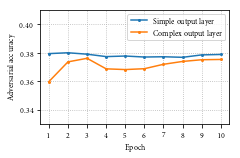

In [22]:
data = [
    zip(range(1, 11), frozen_model_history.history["val_acc"]),
    zip(range(1, 11), complex_output_model_history.history["val_acc"]),
]

legend = ["Simple output layer", "Complex output layer"]

save_plot(data, legend=legend, min_y=0.33, max_y=0.41, output="output_globally_optimal.pdf")